# BayesLDM Quickstart

# <a href="https://colab.research.google.com/github/reml-lab/BayesLDM/blob/main/Examples/BayesLDM_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load dependencies

In [1]:
!pip install BayesLDM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 2.5 MB/s 
     |████████████████████████████████| 74 kB 1.2 MB/s 
     |████████████████████████████████| 292 kB 21.1 MB/s 
     |████████████████████████████████| 174 kB 10.1 MB/s 
     |████████████████████████████████| 54 kB 808 kB/s 
  Created wheel for BayesLDM: filename=BayesLDM-1.0.0-py3-none-any.whl size=16889 sha256=587104795b3569c8cae137dac18c688b39de9a4af065392244dd5a6a057f9057
  Stored in directory: /root/.cache/pip/wheels/dc/86/97/fe25bab0f34e065d48b0a1ef3cb9705e39f39382bb96db231e
Successfully built BayesLDM


## Import modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import BayesLDM.BayesLDM as BayesLDM

# Example 1: Standard Normal Distribution

In this example, we construct a standard normal distribution for the variable  $x$  with the mean fixed at  $0$  and the standard deviation fixed at  $1$. We call the BayesLDM.compile() on the program text to construct the model. We then call model.sample() to draw samples from the model. 
Sampling from the model produces simulations from the generative model specified by the program.

In the call to model.sample(), a random seed is used to initialize the random number generator (by default n_seed=0. We can set n_seed=integer or chosen_rng_key=Jax random number). num_samples is the number of samples to draw. The output of running the program is the set of samples. Statistics on the samples are also shown. The default sampler used is the NumPyro "No U-Turn Sampler" (NUTS).

In [3]:
program = """
ProgramName: Normal
x ~ N(0,1)
"""

model = BayesLDM.compile(program) 
samples = model.sample()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.02      1.00      0.02     -1.63      1.75    376.59      1.01

Number of divergences: 0


The output of the call to model.sample() is a Python distionary with one key for each variable defined through a sampling statement. We can perform any desired analysis on the output samples. In the example below, we plot a histogram of the samples of x using MatplotLib.

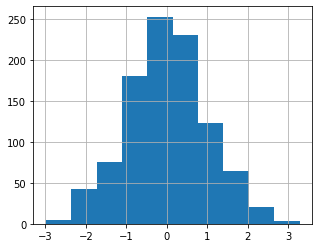

In [4]:
plt.figure(figsize=(5,4))
plt.hist(samples['x'])
plt.grid(); plt.show()

# Example 2:  Basic Autoregressive Models

BayesLDM can be used to specify autoregressive models using indexing in a very natural way. This requires specifying an unconditional distribution over the first time point, followed by a conditional distribution over each subsequent time point conditioned on the value of the previous time point. To provide this functionality, BayesLDM supports basic index arithmetic, as shown in the program below. This program specifies a Normal AR(1) process over 10 time points. We visualize the resulting sets of samples as trajectories through time.

BayesLDM can group the output variables $x[0], ... ,x[9]$, into an array $x$, with shape = $(...,num\_sample)$, where $num\_sample$ is the number of samples to draw, by setting the option $b\_post\_process$ to True.


In [5]:
program = """
ProgramName: BasicAR
Indices: t 0 9

x[0] ~ N(0,1)
x[t] ~ N(0.9*x[t-1],1)

"""

model = BayesLDM.compile(program) 
samples = model.sample(num_samples=20, b_post_process=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]     -0.45      1.18     -0.16     -2.42      1.57      6.35      1.08
      x[1]     -0.85      1.62     -0.32     -3.68      1.15      5.20      1.12
      x[2]     -1.02      1.93     -0.42     -4.63      1.06      6.13      1.16
      x[3]     -1.51      1.80     -1.60     -4.88      0.94      7.65      0.97
      x[4]     -1.44      1.91     -1.63     -4.28      1.27     10.29      0.95
      x[5]     -1.69      1.61     -1.96     -3.62      1.35      8.44      0.99
      x[6]     -1.05      1.79     -1.24     -3.61      1.67      8.16      0.98
      x[7]     -1.47      1.66     -2.08     -3.35      1.89      9.56      0.97
      x[8]     -1.17      1.45     -0.98     -3.54      0.63      7.01      0.99
      x[9]     -0.87      1.42     -1.20     -2.85      1.37      6.46      1.08

Number of divergences: 0


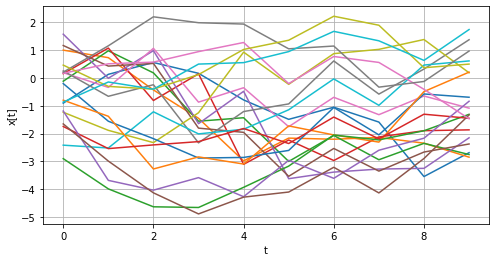

In [6]:
plt.figure(figsize=(8,4))
for s in range(20):
  plt.plot(samples["x"][:,s])
plt.xlabel("t")
plt.ylabel("x[t]")
plt.grid(); plt.show()

# Example 3: Basic Inference

In this example, we consider a simple generative process where mean and standard deviation values (*m* and *s*) are selected once and then multiple observed data values *x[0],...,x[N]* are generated according to the normal distribution *N(m,s)*. We will assume that *m* and *s* are not observed
and draw samples from the posterior distribution conditioned on *x[0],...,x[N]*.

To begin, we construct a Pandas data frame with data sampled directly from a normal distribution with mean *m=5* and standard deviation *s=1*. The data cases are indexed by *n* and we name the single column *x*. The data set contains *N=10* observations, one per row. During inference, we will condition on the data only, simulating the typical scenario that the mean and standard deviation are unknown. 

In [7]:
N=10
df = pd.DataFrame(data={'n':range(N), 'x':5+np.random.randn(N)})
df = df.set_index('n')
df.name='df'
display(df)

,x
n,
0,4.920600
1,4.265885
2,4.430482
3,4.146948
4,3.546348
5,3.712331
6,4.271759
7,3.955112
8,6.120375


Next, we construct a BayesLDM program that expresses a generative process for these data. As noted above, we assume that the data are identically distributed with an unknown mean m and an unknown standard deviation s. To perform Bayesian inference for the unknown model parameters *m* and *s*, we specify prior distributions over their values. 

We assume that *m* is normally distributed with mean 0 and standard deviation 10, creating a broad distribution over possible mean values. We assume that the standard deviation *s* is exponentially distributed with parameter 0.1, creating a broad distribution over possible values for the unknown standard deviation parameter. Finally, we define the indexed vriable *x[n]* to be sampled from a normal distribution with mean *m* and standard deviation *s*. In the program header, we declare *n* as an index variable with the range 0,9.

Before conditioning on the data set, we will simulate from the model and visualize the prior distributions over *m* and *s*. As we would expect, most of the probability mass for *m* is contained in the [-20,20] interval with the mean at 0 while the bulk of the probability mass for *s* in contained in the range [0,10].

In [8]:
program = """
ProgramName: BasicInference
Indices: n 0 9

m ~ N(0,10)
s ~ Exp(0.5)

x[n] ~ N(m,s)

"""

model1 = BayesLDM.compile(program) 
samples1 = model1.sample(b_post_process=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         m     -1.55      9.14     -1.32    -16.73     12.58     41.95      1.06
         s      2.66      2.02      2.03      0.55      5.40     50.16      1.00
      x[0]     -1.63      9.78     -1.30    -16.84     14.50     50.96      1.05
      x[1]     -1.52      9.90     -1.47    -17.82     14.14     37.61      1.05
      x[2]     -1.56      9.69     -1.51    -18.42     13.27     45.82      1.05
      x[3]     -1.65      9.64     -1.66    -18.44     12.83     53.20      1.05
      x[4]     -1.49      9.80     -1.53    -16.58     15.20     40.96      1.06
      x[5]     -1.60      9.77     -1.52    -19.33     12.13     46.91      1.06
      x[6]     -1.60      9.60     -1.33    -16.39     14.45     44.40      1.06
      x[7]     -1.61      9.73     -1.71    -17.44     13.71     44.23      1.05
      x[8]     -1.44      9.94     -1.29    -17.81     14.27     51.72      1.05
      x[9]     -1.55      9

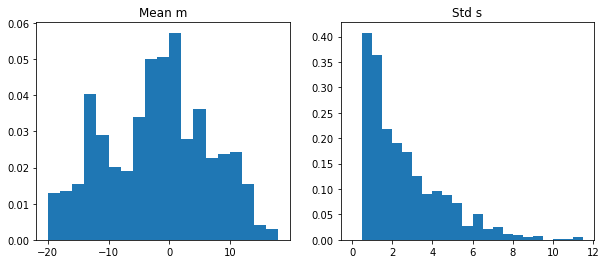

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(samples1['m'], density=True, bins=np.arange(-20,20,2))
plt.title("Mean m")

plt.subplot(1,2,2)
plt.hist(samples1['s'], density=True, bins=np.arange(0,12,0.5))
plt.title("Std s"); plt.show()

Next, we condition the same model on the data frame created above. As noted previously the range of the index variable *n* is automatically inferred from the input data frame *df*. We then draw samples from the posterior distribution of the unknown parameters *m* and *s* given the data. As we can see, the posterior mean for *m* is approximately 5, while the posterior mean for *s* is close to 1. The posterior distributions for both parameters are considerably more concentrated compared to the corresponding prior distributions.

In [10]:
model2 = BayesLDM.compile(program, obs=['x'], data=[df]) 
samples2 = model2.sample(b_post_process=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         m      4.45      0.27      4.45      3.97      4.84    828.72      1.00
         s      0.85      0.22      0.81      0.51      1.15    369.96      1.00

Number of divergences: 0


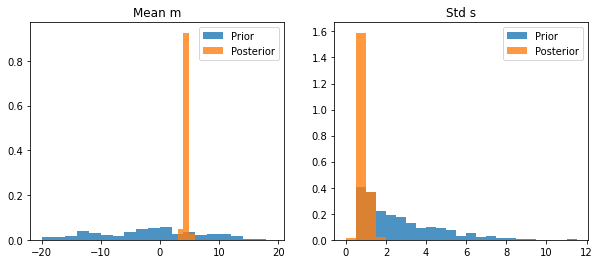

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(samples1['m'], density=True, bins=np.arange(-20,20,2), alpha=0.8);
plt.hist(samples2['m'], density=True, bins=np.arange(-20,20,1), alpha=0.8); 
plt.legend(["Prior","Posterior"]); plt.title("Mean m")

plt.subplot(1,2,2)
plt.hist(samples1['s'], density=True, bins=np.arange(0,12,0.5), alpha=0.8);
plt.hist(samples2['s'], density=True, bins=np.arange(0,12,0.5), alpha=0.8);
plt.legend(["Prior","Posterior"]); plt.title("Std s"); plt.show()